# Practical, methodological and theoretical grounds

## Data 

### Simulation

We will start by simulating data to demonstrate the HMP analysis on simulated data.
First, we need to load several libraries, after which we simulate a dataset with 4 events and the resulting 5 inter-event times (stimulus -> event 1, event 1 -> event 2, ..., event 4 -> response.

In [1]:
## Importing these packages is specific for this simulation case
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma

## Importing HMP
import hmp
from hmp import simulations

In [2]:
cpus = 2 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM

n_trials = 100 #Number of trials to simulate
sfreq = 500
##### Here we define the sources of the brain activity (event) for each trial
n_events = 4
frequency = 10. #Frequency of the event defining its duration, half-sine of 10Hz = 50ms
amplitude = .2e-7 #Amplitude of the event in nAm, defining signal to noise ratio
shape = 2 #shape of the gamma distribution
means = np.array([60, 150, 200, 100, 80])/shape #Mean duration of the between event times in ms
names = ['inferiortemporal-lh','caudalanteriorcingulate-rh','bankssts-lh','superiorparietal-lh','superiorparietal-lh']#Which source to activate for each event (see atlas when calling simulations.available_sources())

sources = []
for source in zip(names, means): #One source = one frequency, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency, amplitude, gamma(shape, scale=source[1])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, 'dataset_raw', overwrite=False, sfreq=sfreq, seed=1)
#load electrode position, specific to the simulations
info = simulations.simulation_positions()

/home/gweindel/owncloud/projects/RUGUU/main_hmp/hmp/simulations.py:190: UserWarning: ./dataset_raw_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


Next, we load the simulated data, reflecting a realistic EEG dataset of a single participant. As you can see, we use standard MNE functions here.

In [3]:
#Recovering the events to epoch the data (in the number of trials defined above)
events = np.load(file[1])
resp_trigger = int(np.max(np.unique(events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}
#Keeping only stimulus and response triggers


#Visualising the raw simulated EEG data
import mne
raw = mne.io.read_raw_fif(file[0], preload=False, verbose=False)
raw.pick_types(eeg=True).plot(scalings=dict(eeg=1e-5), events=events, block=True);


### Data Format 
We now prepare the data for the HMP package. First, we read the data into an xarray.

In [4]:
# Reading the data
epoch_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, sfreq=sfreq, 
            events_provided=events, verbose=False)
epoch_data

Processing participant ./dataset_raw_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/main_hmp/lib/python3.12/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


100 trials were retained for participant ./dataset_raw_raw.fif


<xarray.Dataset> Size: 34MB
Dimensions:      (participant: 1, epochs: 100, channels: 59, samples: 719)
Coordinates:
  * epochs       (epochs) int64 800B 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * channels     (channels) <U7 2kB 'EEG 001' 'EEG 002' ... 'EEG 059' 'EEG 060'
  * samples      (samples) int64 6kB 0 1 2 3 4 5 6 ... 713 714 715 716 717 718
    event_name   (epochs) object 800B 'stimulus' 'stimulus' ... 'stimulus'
    rt           (epochs) float64 800B 0.28 0.432 0.718 ... 0.806 0.316 0.83
  * participant  (participant) <U2 8B 'S0'
Data variables:
    data         (participant, epochs, channels, samples) float64 34MB -1.481...
Attributes:
    sfreq:             500.0
    offset:            0
    lowpass:           40.0
    highpass:          0.10000000149011612
    lower_limit_RT:    0
    upper_limit_RT:    5.002
    reject_threshold:  inf
    n_trials:          100

The previous function epochs the data, cut the EEG data at each RT value and stores any additional infomation along (here 'event_name').

xarray is a handy way of using matrices with named dimensions. For example we can now very easily draw an ERP:


<xarray.Dataset> Size: 34MB
Dimensions:      (participant: 1, epochs: 100, channels: 59, samples: 719)
Coordinates:
  * epochs       (epochs) int64 800B 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * channels     (channels) <U7 2kB 'EEG 001' 'EEG 002' ... 'EEG 059' 'EEG 060'
  * samples      (samples) int64 6kB 0 1 2 3 4 5 6 ... 713 714 715 716 717 718
    event_name   (epochs) object 800B 'stimulus' 'stimulus' ... 'stimulus'
    rt           (epochs) float64 800B 0.28 0.432 0.718 ... 0.806 0.316 0.83
  * participant  (participant) <U2 8B 'S0'
Data variables:
    data         (participant, epochs, channels, samples) float64 34MB -1.481...
Attributes:
    sfreq:             500.0
    offset:            0
    lowpass:           40.0
    highpass:          0.10000000149011612
    lower_limit_RT:    0
    upper_limit_RT:    5.002
    reject_threshold:  inf
    n_trials:          100


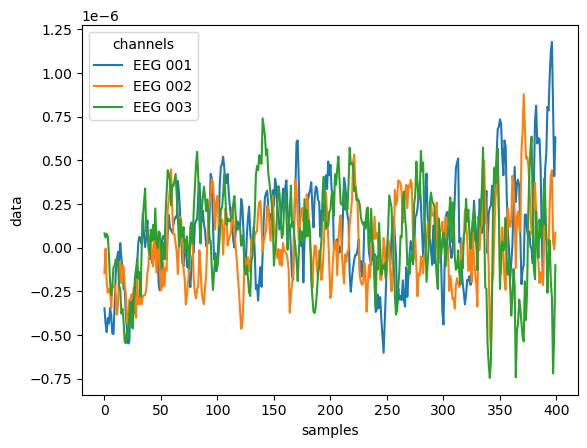

In [5]:
#example of usage of xarray
print(epoch_data)
epoch_data.sel(channels=['EEG 001','EEG 002','EEG 003'], samples=range(400))\
    .data.groupby('samples').mean(['participant','epochs']).plot.line(hue='channels')
plt.show()

Next, we transform the data for HMP:
- Apply PCA and select top components to lower computational load
- zscore the data per trial

This analysis step asks you to choose a number of PC components; in the case of this simulated data, and for illustrative purposes we take 4 components (more on this with real data in Tutorial 3).

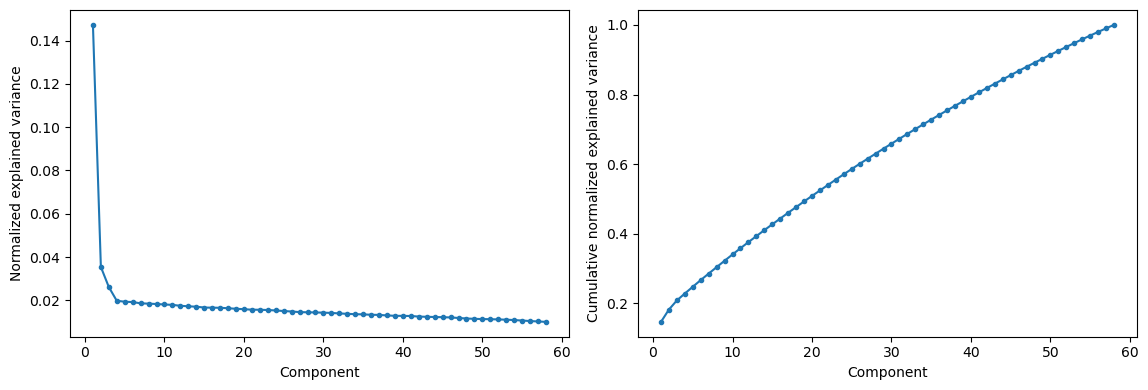

How many PCs (95 and 99% explained variance at component n54 and n58; components till n58 explain at least 1%)? 4


In [6]:
hmp_data = hmp.utils.transform_data(epoch_data, apply_standard=False)

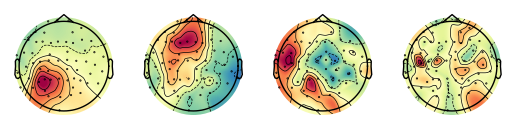

In [7]:
hmp.visu.plot_components_sensor(hmp_data, info)

## HMP and implementation assumptions

HMP uses classes to instantiate fit of hmp models. Therefore before estimating a model one needs to declare an instance of the hmp class by specifying the data, the sampling frequency of the data as well as several parmeters such as the target event width (in milliseconds) and the expected distribution (both family and shape).

By default, we use the same assumptions for the events and between events time distributions as in the original paper of Anderson, Zhang, Borst & Walsh, 2016. That is, we use an event template of a half sine wave and gamma distributions with a shape parameter of 2 to model the data. Note that you can very easily use other templates and distributions in HMP.

In the next step, we initialize an hmp model 'init' with those standard settings, using the data we simulated above.

In [8]:
init = hmp.models.hmp(data=hmp_data, epoch_data=epoch_data, sfreq=epoch_data.sfreq,
                      event_width=50, distribution='gamma', shape=2)

We can view the template used by init: a 50 ms bump (i.e. a 10Hz half-sin):

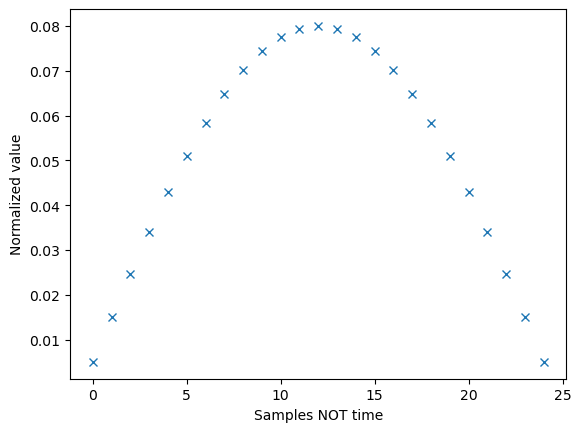

In [9]:
plt.plot(init.template, 'x')
plt.ylabel('Normalized value')
plt.xlabel('Samples NOT time')
plt.show()

When calling ```hmp.models.hmp```, the function automatically cross-correlated the data with the provided template, to get an estimate of where the EEG data looks like the template.

Below, we plot those cross-correlated values; the vertical lines indicate the start of the events in the simulated data.

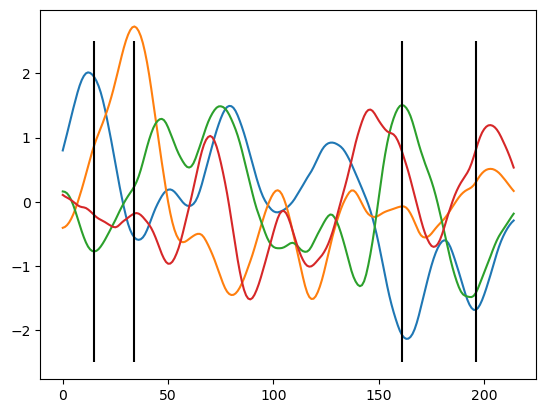

In [10]:
plt.plot(init.events[init.starts[1]:init.ends[1]])

#Recover the actual time of the simulated events
sim_source_times = np.reshape(np.ediff1d(events[:,0],to_begin=0)[events[:,2] > 1], (n_trials, n_events+1))
plt.vlines(sim_source_times[1,:-1].cumsum(), -2.5, 2.5, 'k') #overlaying the simulated event onset times
plt.show()

### HMP parameters

An HMP model tries to recover the underlying magnitudes (= EEG/MEG topographies) and inter-event time distribution parameters from the data. Here, we first we retrieve the actual generating parameters from the simulation, in order to judge how well the HMP recovery works.

In [11]:
sim_source_times, true_pars, true_magnitudes, _ = simulations.simulated_times_and_parameters(events, init)

As an exceedingly simple example, we will first feed these parameters and magnitudes into the HMP model fitting procedure as starting points, and try to estimate a model.

We do that by calling `fit_single` on `init`, and telling it to recover 4 events and using the true parameters and magnitudes as starting points. We also tell it that it does not in fact have to maximize the fit.

Estimating 4 events model
parameters estimated for 4 events model


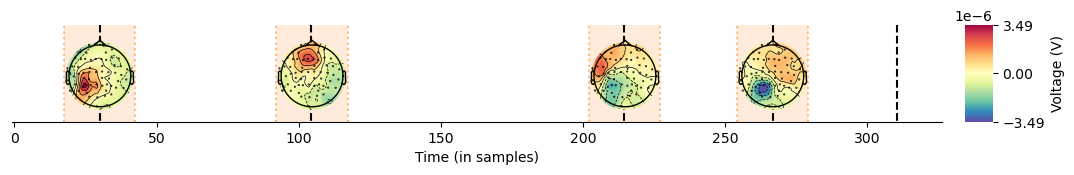

In [12]:
estimates = init.fit_single(n_events, parameters = true_pars, magnitudes=true_magnitudes, maximization=False)

hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, init, magnify=1, sensors=True, times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

In the plot above we see the four recovered events; the vertical lines again indicate the peak of the actual events. Not surprisingly, the recovery is perfect.

The first element that we fed into the fit_single function were the expected distributions for between event duration, `true_pars`. Let's have a look at those:

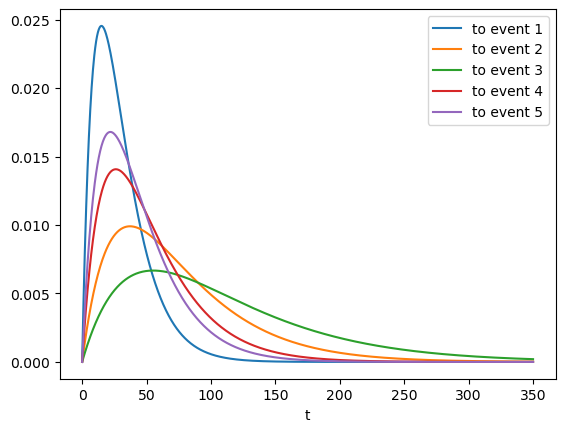

In [13]:
colors = sns.color_palette(None, n_events+1)

T = 350
for event in range(5):
    plt.plot(np.linspace(0,T,1001),gamma.pdf(np.linspace(0,T,1001), 2, scale=true_pars[event,1]), label=f'to event {event+1}', color=colors[event]) 
plt.xlabel('t')
plt.legend()
plt.show()

The width of these distribution indicates the variability of the between-event durations over trials and (with real data) participants.

The second element is the contribution of the different electrodes/magnometers/PCs to each of the event, the `true_mags`. Here we get the estimated magnitudes:

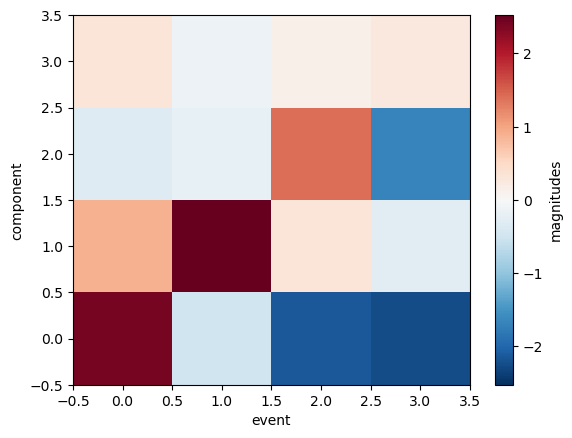

In [14]:
estimates.magnitudes.dropna('event').T.plot()
plt.show()

We used 4 PC components (y-axis) to estimate 4 events. As is visible in the matrix above, each event has a unique combination of component contributions, although this is not a requirement.

To estimate this set of parameters (magnitudes and time distributions) we use the expectation maximization algorithm on the event probability as obtained through the Baum-Welsh algorithm. 

Now we do not provide the true magnitudes and parameters as starting points, but start with neutral ones (0's for the magnitudes, mean duration / n_events for the average between event duration).

Estimating 4 events model with 1 starting point(s)
parameters estimated for 4 events model


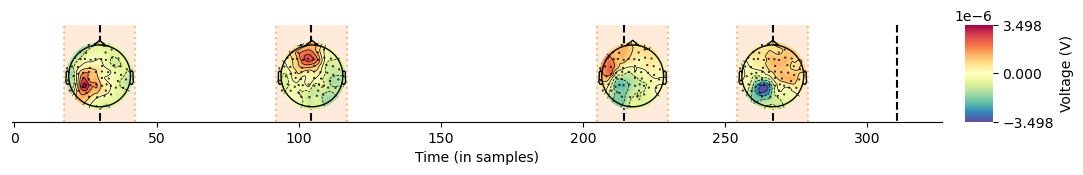

In [15]:
estimates = init.fit_single(n_events)

hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, init, magnify=1, sensors=True, times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

Also without providing the true magnitudes and parameters, the algorithm manages to recover the events in the simulated data.

We can inspect the traces of the EM algorithm to see how the log-likelihood of the fit developed with iterations. This shows how many iterations it needed and at what Log-likelihood (LL) it stopped according to the default tolerance on the increase in LL (default 1e-4).

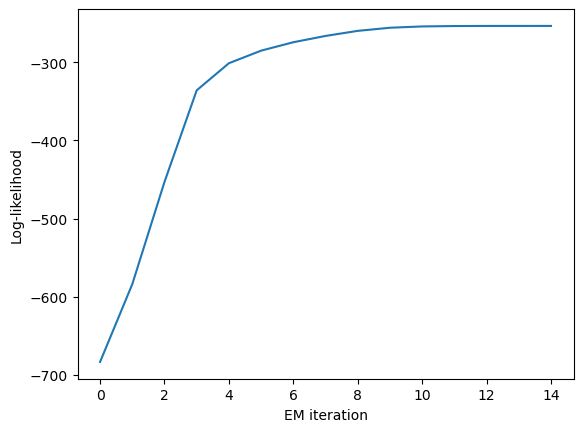

In [16]:
plt.plot(estimates.traces)
plt.ylabel('Log-likelihood')
plt.xlabel('EM iteration')
plt.show()

For simulated data, we can also check how well our model recovered the original values for the electrode contributions and time distributions.

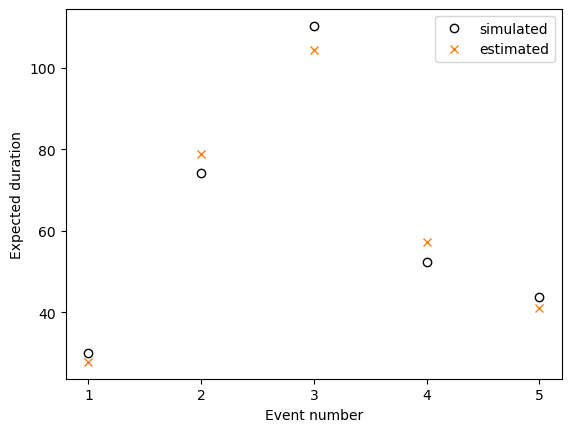

In [17]:
plt.plot(true_pars.prod(axis=1), 'o', label='simulated',mec='k', mfc='w', )
plt.plot(estimates.parameters.prod(axis=1), 'x', label='estimated')#prod() is for a gamma only
plt.xticks(range(5),[1,2,3,4,5])
plt.legend()
plt.xlabel('Event number')
plt.ylabel('Expected duration')
plt.show()

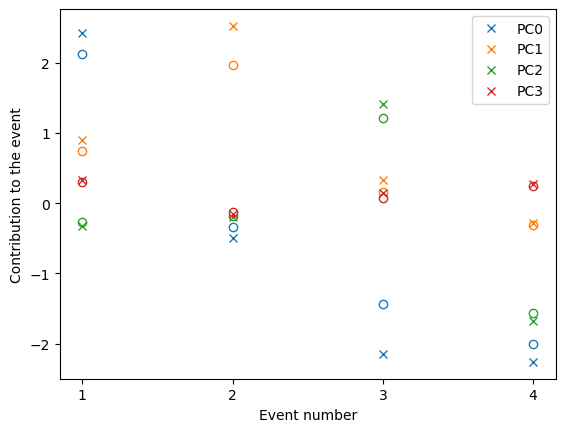

In [18]:
for pc in range(init.n_dims):
    plt.plot(estimates.magnitudes.sel(component=pc), 'o', mec=colors[pc], mfc='w')
    plt.plot(true_magnitudes[:,pc], 'x', label=f'PC{pc}', color=colors[pc])
plt.xticks(range(4),[1,2,3,4])
plt.xlabel('Event number')
plt.ylabel('Contribution to the event')
plt.legend()
plt.show()

## Exploiting model estimates

In the end, what we are really interested in is the event probabilities, the probability of event occurring at each sample in every trial of every participants, as this allows us to do interesting follow-up analyses.

Let's check what these look like:

In [19]:
estimates.eventprobs

<xarray.DataArray 'eventprobs' (trial_x_participant: 100, samples: 719, event: 4)> Size: 2MB
array([[[0.00000000e+00, 4.51126728e-20, 0.00000000e+00, 0.00000000e+00],
        [1.28228499e-03, 2.68192152e-19, 0.00000000e+00, 0.00000000e+00],
        [2.27462591e-03, 2.03584168e-07, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 5.95303176e-21, 7.38849821e-22, 9.58978373e-25],
        [7.68261417e-04, 2.37926828e-21, 0.00000000e+00, 0.00000000e+00],
        [1.92011698e-03, 4.57429564e-09, 4.37907084e-22, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 6.17243555e-23, 0.00000000e+00],
        [2.06903433e-05, 9.32680419e-21, 3.60747492e-23, 0.00000000e+00],
        [5.06599627e-05, 3.47737228e-10, 7.59431970e-23, 0.00000000e+00],
        ...,
...
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 1.20547915e-20, 2.56134320e-21, 0.00000000e+00],
        [4.65789933e-04, 1.13217693e-20, 0.00000000e+00, 0.00000000e+00],
        [9.95612693e-04, 1.51277642e-08, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 6.98777551e-21, 0.00000000e+00, 0.00000000e+00],
        [9.32452297e-05, 1.01648927e-20, 2.35352727e-23, 0.00000000e+00],
        [1.72101343e-04, 2.17755229e-09, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * event                (event) int64 32B 0 1 2 3
  * samples              (samples) int64 6kB 0 1 2 3 4 5 ... 714 715 716 717 718
  * trial_x_participant  (trial_x_participant) object 800B MultiIndex
  * participant          (trial_x_participant) object 800B 'S0' 'S0' ... 'S0'
  * trials               (trial_x_participant) int64 800B 0 1 2 3 ... 97 98 99

This is a matrix with dimensions trial x sample_in_trial x event, where the values indicate the probablity of that event occurring at that sample.

We can represent this graphically, for example by plotting the average probability for each event at each time sample:

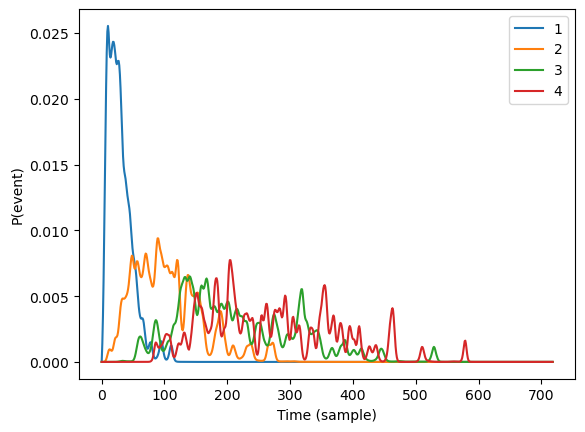

In [20]:
plt.plot(estimates.eventprobs.mean('trial_x_participant'), label=[1,2,3,4])
plt.ylabel('P(event)')
plt.xlabel('Time (sample)')
plt.legend()
plt.show()

And we can even look at a single trial:

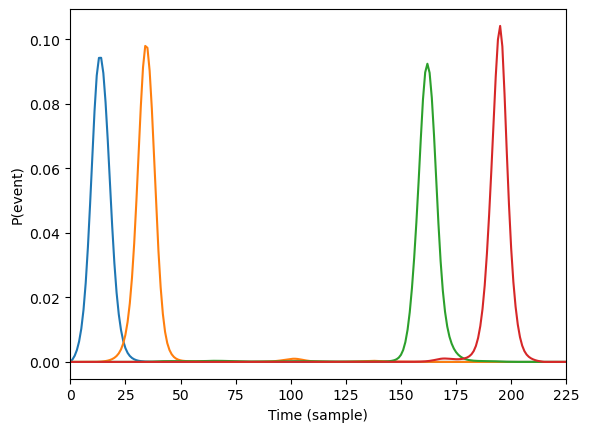

In [21]:
plt.plot(estimates.eventprobs.sel(trial_x_participant=('S0',1)), label=[1,2,3,4])
plt.ylabel('P(event)')
plt.xlabel('Time (sample)')
plt.xlim(0,225)
plt.show()

And in the case of simulation compare that to the actual generating moment for the corresponding trials:

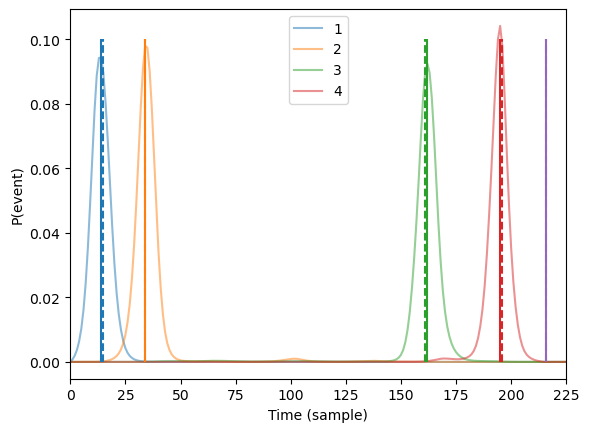

In [22]:
estimated_times = init.compute_times(init, estimates, duration=True, mean=False, add_rt=True).T
plt.plot(estimates.eventprobs.sel(trial_x_participant=('S0',1)), label=[1,2,3,4], alpha=.5)
plt.ylabel('P(event)')
plt.xlabel('Time (sample)')
plt.vlines(np.cumsum(sim_source_times[1,:]), 0,.1, color=colors, ls='--')
plt.vlines(np.cumsum(estimated_times.sel(trial_x_participant=('S0',1))), 0,.1, color=colors, ls='-')
plt.legend()
plt.xlim(0,225)
plt.show()

Here the solid lines are the estimated times, while the dotted lines in indicate the simulated events. For this trial, the estimation procedure had trouble locating the fourth events because it does share some information in terms of magnitudes with the third one.

If we select for all trials the most likely sample to contain a transition we can take a look at the recovery of our simulated times on all trials:

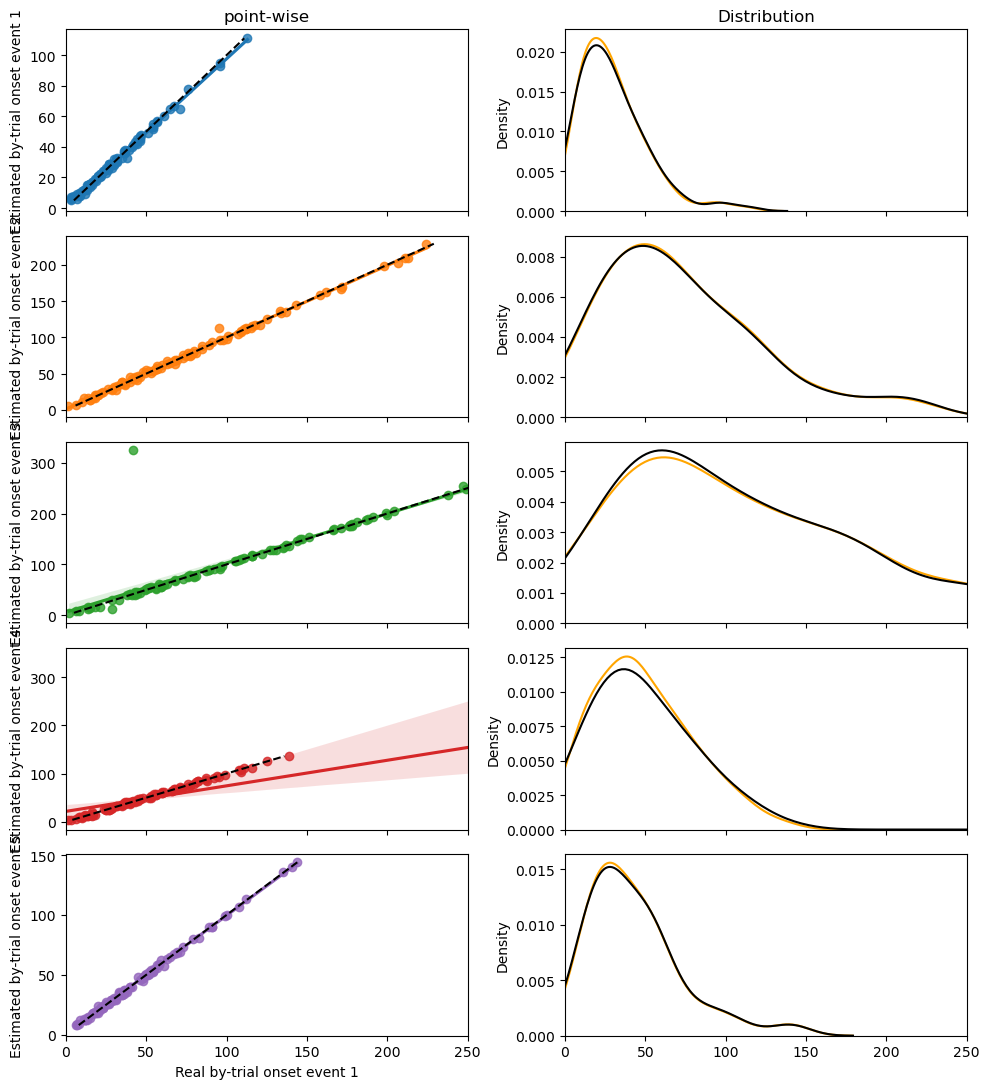

In [23]:
fig, ax = plt.subplots(n_events+1,2, figsize=(10,2.5*n_events+1), dpi=100, sharex=True)
i = 0
ax[0,0].set_title('point-wise')
ax[0,1].set_title('Distribution')
ax[-1,0].set_xlabel(f'Real by-trial onset event {i+1}')

for event in estimated_times:
    sns.regplot(x=sim_source_times[:,i].T, y=event, ax=ax[i,0], color=colors[i])
    ax[i,0].plot([np.min(event), np.max(event)], [np.min(event), np.max(event)],'--', color='k')
    ax[i,0].set_ylabel(f'Estimated by-trial onset event {i+1}')
    sns.kdeplot(event, ax=ax[i,1], color='orange')
    sns.kdeplot(sim_source_times[:,i].T, ax=ax[i,1], color='k')
    i+= 1

plt.xlim(0,250)
plt.tight_layout()
plt.show()

As you can see some trials get miss-estimated from the 3rd to the 4th event (red). Consequently those trials are also mis-estimating in the times between the 4th and the response time. This is related to the confusion between the 3rd and fourt event outlined previously. 

But overall the exact time of the simulated event is detected as the most likely time by HMP!

# Exercise
Now based on the assumptions of an HMP model in terms of expected between event time distribution and length of the event suggest an alternative HMP model and test the recovery of the original parameters (event duration of 50ms)

Estimating 4 events model with 1 starting point(s)
parameters estimated for 4 events model


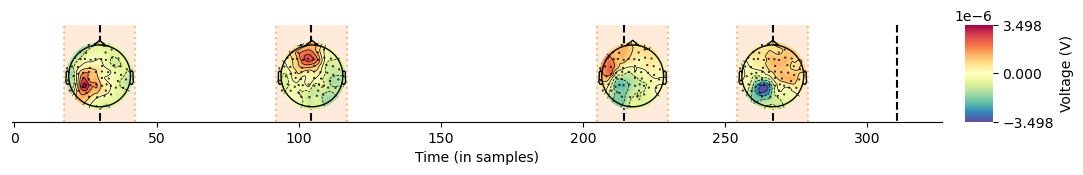

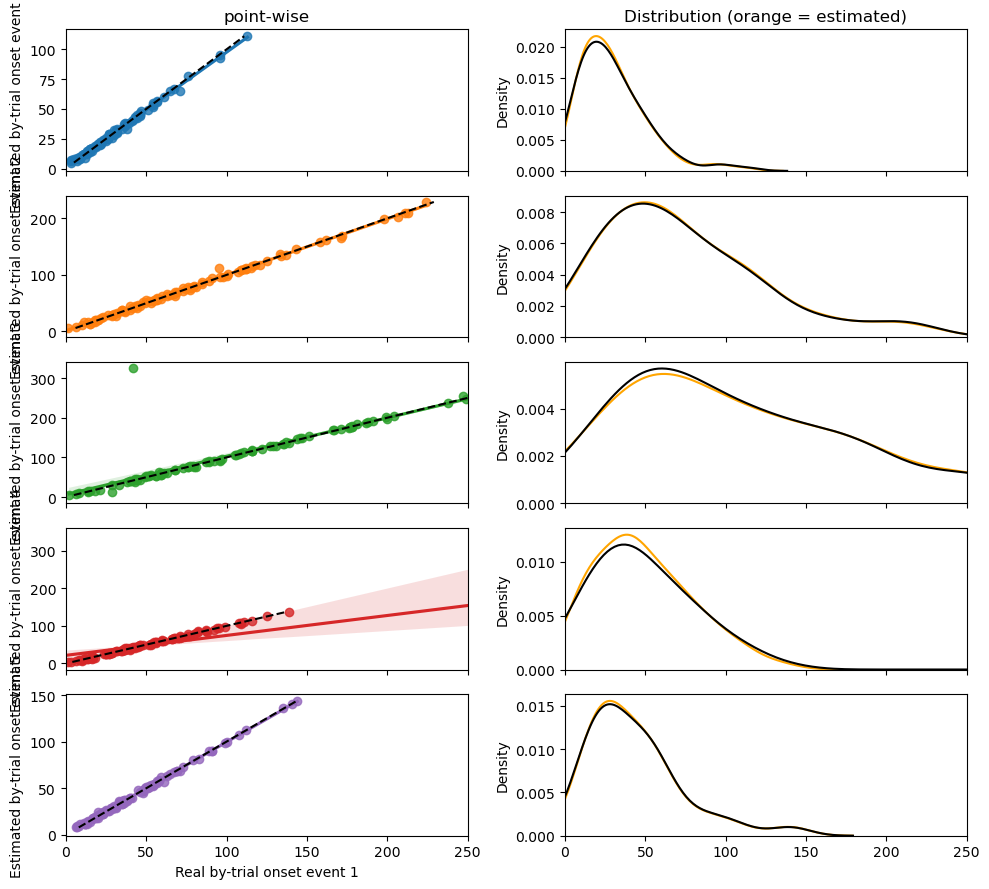

In [24]:
init = hmp.models.hmp(data=hmp_data, epoch_data=epoch_data, sfreq=epoch_data.sfreq,
                      event_width=50)#Change here 

estimates = init.fit_single(n_events)
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, init, magnify=1, sensors=True, times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

fig, ax = plt.subplots(n_events+1,2, figsize=(10,2*n_events+1), dpi=100, sharex=True)
i = 0
ax[0,0].set_title('point-wise')
ax[0,1].set_title('Distribution (orange = estimated)')
ax[-1,0].set_xlabel(f'Real by-trial onset event {i+1}')

for event in init.compute_times(init, estimates, duration=True, mean=False, add_rt=True).T:
    sns.regplot(x=sim_source_times[:,i].T, y=event, ax=ax[i,0], color=colors[i])
    ax[i,0].plot([np.min(event), np.max(event)], [np.min(event), np.max(event)],'--', color='k')
    ax[i,0].set_ylabel(f'Estimated by-trial onset event {i+1}')
    sns.kdeplot(event, ax=ax[i,1], color='orange')
    sns.kdeplot(sim_source_times[:,i].T, ax=ax[i,1], color='k')
    i+= 1

plt.xlim(0,250)
plt.tight_layout()
plt.show()